In [1]:
import local_models.local_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import local_models.loggin
import local_models.TLS_models
import local_models.algorithms
import local_models.linear_projections
import sklearn.gaussian_process as gp
import patched_gpr
from gpr_utils import *


logger = logging.getLogger(__name__)

np.random.seed(1)
reload(local_models.local_models)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [2]:
mpl.rcParams['figure.figsize'] = [16.0, 8.0]
mpl.rcParams['font.size'] = int(mpl.rcParams['figure.figsize'][1]*3)
import cycler
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', CB_color_cycle)

In [3]:
RUN = 4
HZ = 1
project_dir = "../data/local_gpr_contrived_variance_{:02d}".format(RUN)
os.makedirs(project_dir, exist_ok=1)

## Variable Noise

In [4]:
X = np.linspace(1,1000,1000).reshape((-1,1))
index = local_models.local_models.ConstantDistanceSortedIndex(X.flatten())
y = 10*np.sin(X/50)
y[:450,0] += np.random.normal(0,1,450)
y[450:550,0] += np.random.normal(0,5,100)
y[550:,0] += np.random.normal(0,1,450)
change_points = np.array([450,550])

In [5]:
bandwidth = 120
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)

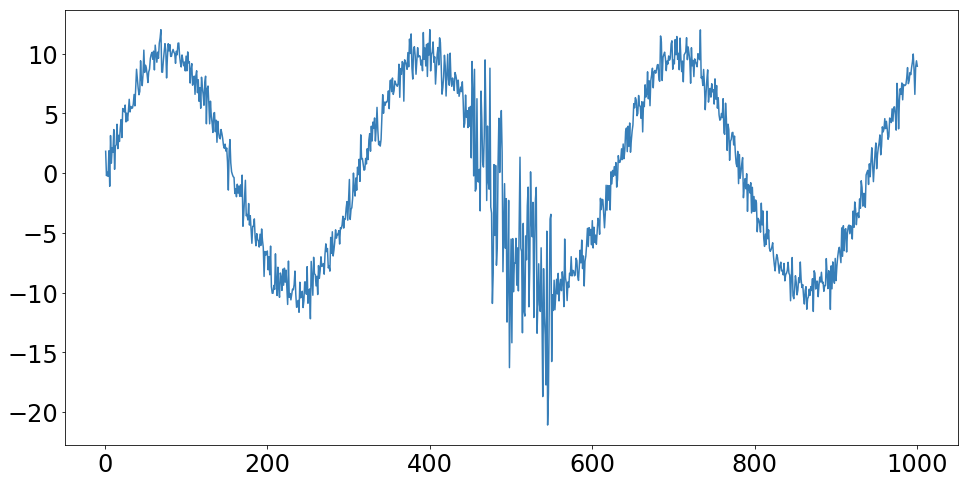

In [6]:
plt.plot(X,y)
plt.show()

In [7]:
kernel = np.sum((
    #gp.kernels.ConstantKernel(constant_value=1.0, constant_value_bounds=[0.001,100]), 
    np.prod((
        gp.kernels.ConstantKernel(constant_value=10, constant_value_bounds=[1e-10,1e10]),
        gp.kernels.RBF(length_scale=10., length_scale_bounds=[1e-10,1e10])
    )),
    gp.kernels.WhiteKernel(noise_level=10, noise_level_bounds=[1e-10,1e10])
))

In [8]:
exemplar_regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=400, alpha=0)

In [9]:
exemplar_rng = (bandwidth, 3*bandwidth-2)
exemplar_X = X[slice(*exemplar_rng)]
exemplar_y = y[slice(*exemplar_rng)]
exemplar_regressor.fit(
    exemplar_X, 
    exemplar_y, 
    sample_weight = lm_kernel(np.abs(exemplar_X - np.mean(exemplar_X)))[:,0])

GPR(alpha=0, copy_X_train=True,
    kernel=3.16**2 * RBF(length_scale=10) + WhiteKernel(noise_level=10),
    n_restarts_optimizer=400, normalize_y=True, optimizer='fmin_l_bfgs_b',
    random_state=None)

In [10]:
np.exp(exemplar_regressor.kernel_.theta)

array([ 1.52399877, 22.19316901,  3.60825913])

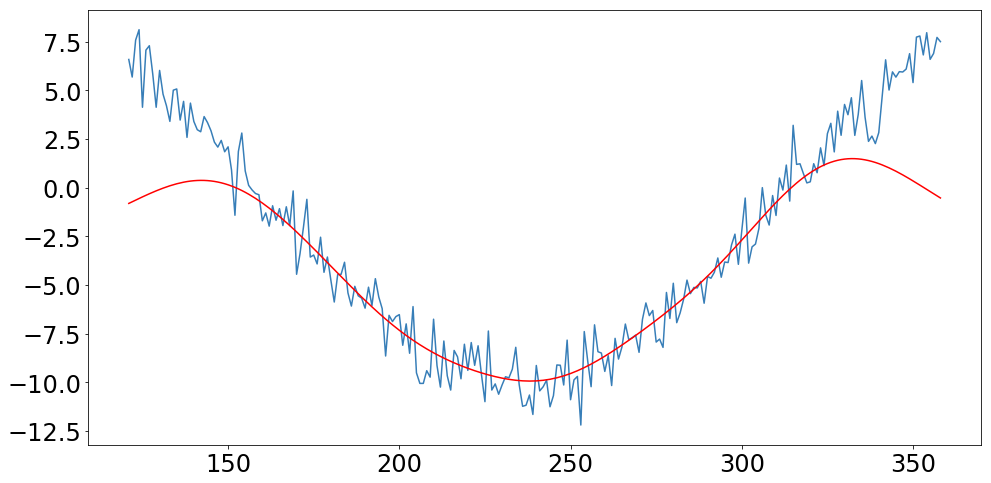

In [11]:
plt.plot(exemplar_X,exemplar_y)
plt.plot(exemplar_X,exemplar_regressor.predict(exemplar_X),c='r')
plt.savefig(os.path.join(project_dir, "exemplar_variable_noise_b{:07.02f}_rng{}.png".format(bandwidth, str(exemplar_rng))))

In [7]:
FRESH=True
dat_dir = os.path.join(project_dir, "dat_variable_noise_01")
os.makedirs(dat_dir, exist_ok=1)

In [14]:
cvs = 2.**np.arange(-2,16)
rbfs = 2.**np.arange(-3,10)*HZ

In [15]:
for cv in cvs:
    for rbf in rbfs:
        kernel = np.sum((
            np.prod((
                gp.kernels.ConstantKernel(constant_value=cv, constant_value_bounds="fixed"),
                gp.kernels.RBF(length_scale=rbf, length_scale_bounds="fixed")
            )),
            gp.kernels.WhiteKernel(noise_level=cv, noise_level_bounds=[1e-10,1e10])
        ))
        regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, alpha=0)
        gpr_models = local_models.local_models.LocalModels(regressor)

        print(cv, rbf)
        gpr_models.fit(X, y, index=index)
        gpr_params = gpr_models.transform(X,
            r=lm_kernel.support_radius()-1, weighted=True, kernel=lm_kernel,
            neighbor_beta0s=False, batch_size=int(X.shape[0]/10))
        filename = os.path.join(project_dir, "c{:10.02f}_r{:05.02f}_k{}.png".format(kernel.k1.k1.constant_value, kernel.k1.k2.length_scale, lm_kernel))
        plt_gpr_params(X/HZ, y, 
            X/HZ, gpr_params, 
            chg_ptses=[change_points/HZ],
            filename=filename, kernel=kernel, display=True)

0.25 0.125


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [8]:
#illustrative_cv_rbf_pairs = [(32,8),(64,2),(64,512),(.25,.12),(.25,2)]
illustrative_cv_rbf_pairs = [(64,512)]

In [ ]:
gpr_paramses = []
for cv, rbf in illustrative_cv_rbf_pairs:
    kernel = np.sum((
        np.prod((
            gp.kernels.ConstantKernel(constant_value=cv, constant_value_bounds=[1e-10,1e10]),
            gp.kernels.RBF(length_scale=rbf, length_scale_bounds=[1e-10,1e10])
        )),
        gp.kernels.WhiteKernel(noise_level=cv, noise_level_bounds=[1e-10,1e10])
    ))
    regressor = GPRNeighborFixedMixt(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, alpha=0)
    gpr_models = local_models.local_models.LocalModels(regressor)

    print(cv, rbf)
    gpr_models.fit(X, y, index=index)
    gpr_params = gpr_models.transform(X,
        r=lm_kernel.support_radius()-1, weighted=True, kernel=lm_kernel,
        neighbor_beta0s=True, batch_size=int(X.shape[0]/10))
    gpr_paramses.append(gpr_params)



64 512


In [ ]:
gpr_paramses = np.stack(gpr_paramses, axis=2)

In [ ]:
gpr_paramses.shape

In [ ]:
filename = os.path.join(project_dir, "illustrative_pairs.png".format(kernel.k1.k1.constant_value, kernel.k1.k2.length_scale, lm_kernel))
plt_gpr_params(X/HZ, y, 
    X/HZ, gpr_paramses, 
    chg_ptses=[change_points/HZ],
    filename=filename, kernel=kernel, display=True)